In [119]:
import geojson
import numpy as np
from mmap import MAP_ANONYMOUS
import folium
#from shapely.geometry import LineString, Point
#from shapely.ops import transform
#import pyproj
#from math import ceil
import random
import matplotlib.pyplot as plt

In [120]:
with open('lijnsecties-1.json', 'r') as f:
    data = geojson.load(f)

In [121]:
#trajectories_size=[len(np.array(data['features'][i]['geometry']['coordinates'])) for i in range(len(data['features']))]
#print(np.argmax(trajectories_size),np.max(trajectories_size))

In [122]:
#line = np.array(data['features'][360]['geometry']['coordinates'])
#line = np.array(data['features'][359]['geometry']['coordinates'])
#line[:,[0,1]]=line[:,[1,0]]
#map_center=line[400,:]
#mapa = folium.Map(location=map_center, zoom_start=13, width=1600/2, height=900/2)
#folium.PolyLine(locations=line, color='red', weight=3).add_to(mapa)
#mapa

In [123]:
#np.savetxt('line_BEL_360.txt', line, delimiter=',', comments='',fmt='%.7f')
#print("Datos guardados en 'line_BEL_360.txt'")

In [124]:
line=[]
with open("line_BEL_extended.txt", 'r') as f:
    for entry in f:
        coords = entry.strip().split(',')
        line.append([float(coords[0]), float(coords[1])])

line=np.array(line)
line.shape

(976, 2)

In [125]:
map_center=line[500,:]
mapa = folium.Map(location=map_center, zoom_start=13, width=1600/2, height=900/2)
folium.PolyLine(locations=line, color='red', weight=3).add_to(mapa)
mapa

In [126]:
index_sample=random.randint(0,line.shape[0])
err_x=0.05*(np.max(line[:,0])-np.min(line[:,0]))
err_y=0.05*(np.max(line[:,1])-np.min(line[:,1]))
new_point=(line[index_sample,0]+random.choice([1, -1])*err_x,line[index_sample,1]+random.choice([1, -1])*err_y)
print(new_point)
folium.Marker(location=new_point, popup=f"GNSS output").add_to(mapa)

(np.float64(51.0995753), np.float64(3.41047315))


In [127]:
### C file example ###
#new_point=(np.float64(51.1008044), np.float64(3.433197))
#folium.Marker(location=new_point, popup=f"GNSS output").add_to(mapa)

In [128]:
display(mapa)

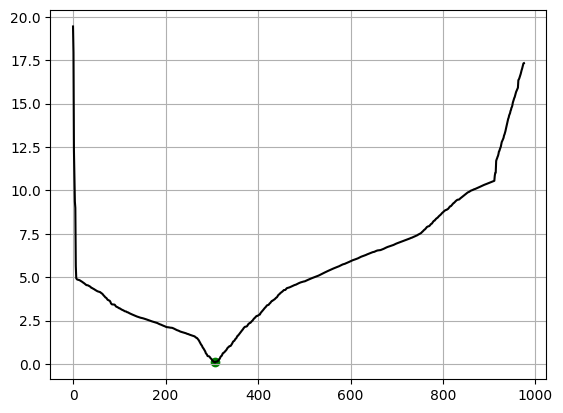

In [129]:
def haversine(coord1, coord2):
    # Convierte las coordenadas de grados a radianes
    lat1, lon1 = np.radians(coord1)
    if coord2.shape==(2,):
        lat2, lon2 = np.radians(coord2)
    else:
        lat2, lon2 = np.radians(coord2[:, 0]), np.radians(coord2[:, 1])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    
    # Radio de la Tierra en kilómetros: 6371
    km = 6371 * c
    return km

distances = haversine(new_point, line)

closest_index = np.argmin(distances)
closest_point = line[closest_index,:]
plt.plot(distances,color="black")
plt.scatter(closest_index,np.min(distances),color='green')
plt.grid(True)
plt.show()

folium.Marker(location=closest_point, popup=f"Closest Point (I)",icon=folium.Icon(color='green')).add_to(mapa)
mapa

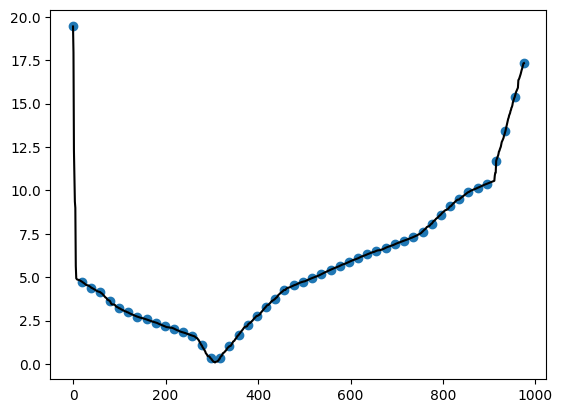

In [130]:
coarse_search_indexes=np.linspace(0,len(line)-1,50,dtype=int)
#plt.plot(line[:,0],distances,color="black")
plt.plot(distances,color="black")
#plt.scatter(line[coarse_search_indexes,0],distances[coarse_search_indexes])
plt.scatter(coarse_search_indexes,distances[coarse_search_indexes])
plt.show()

In [131]:
#coarse_search_indexes=np.linspace(0,len(normalized_line)-1,11,dtype=int)
coarse_search_points=line[coarse_search_indexes]
coarse_points_distances = haversine(new_point, coarse_search_points)
min_p=np.argmin(coarse_points_distances)
new_space=coarse_search_indexes[np.clip([min_p-1,min_p+1],a_min=0,a_max=len(coarse_search_indexes)-1)]
line_shorted=line[new_space[0]:new_space[1]]
print('Search space len: '+ str(len(line_shorted)))
#n_distances=np.linalg.norm(line_shorted - new_point, axis=1)
n_distances = haversine(new_point, line_shorted)
min_ndist_arg=np.argmin(n_distances)
closest_point_II=line[new_space[0]+min_ndist_arg]

Search space len: 40


In [132]:
folium.PolyLine(locations=line_shorted, color='blue', weight=5).add_to(mapa)
folium.Marker(location=closest_point_II, popup=f"Closest Point (II)",icon=folium.Icon(color='black')).add_to(mapa)
print(closest_point,closest_point_II)
if np.array_equal(closest_point_II,closest_point):
    print("Mismo punto en I y en II")
mapa

[51.100266  3.410951] [51.100266  3.410951]
Mismo punto en I y en II


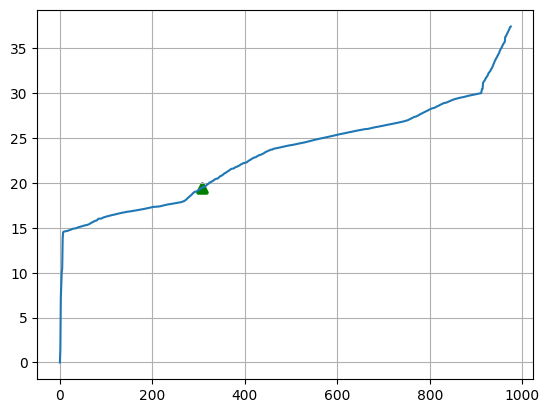

In [133]:
relative_distance=[haversine(line[i], line[i-1]) for i in range(1,len(line))]
relative_distance=[0]+relative_distance
line_position=np.cumsum(relative_distance)
plt.plot(line_position)
plt.scatter(new_space[0]+min_ndist_arg,line_position[new_space[0]+min_ndist_arg],color='g', marker='^',linewidths=3)
plt.grid(True)
plt.show()

In [134]:
haversine(line[0], line[-1])

np.float64(36.21183301425391)